<a href="https://colab.research.google.com/github/ibribr/DT8807/blob/master/Airline_Passengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# Multilayer Perceptron to Predict International Airline Passengers (t+1, given t, t-1, t-2)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, RNN, SimpleRNN, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.utils import plot_model

In [46]:
# load the dataset
url = 'https://raw.githubusercontent.com/ibribr/ML/master/international-airline-passengers.csv'

df = pd.read_csv(url, usecols=[1])
df = df.dropna()
print(df)

dataset = df.values
dataset = dataset.astype("float32")

print('Dataset size:', dataset.shape)
# normalize the dataset
minmax = MinMaxScaler(feature_range=(0,1))
dataset = minmax.fit_transform(dataset)

# split into train and test sets
train_dataset = dataset[:int(len(dataset)*0.7), :]
test_dataset = dataset[int(len(dataset)*0.7):, :]

print('Training set:', len(train_dataset))
print('Test set    :', len(test_dataset))
print(dataset[0:10])

     International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0                                                112.0                             
1                                                118.0                             
2                                                132.0                             
3                                                129.0                             
4                                                121.0                             
..                                                 ...                             
139                                              606.0                             
140                                              508.0                             
141                                              461.0                             
142                                              390.0                             
143                                              432.0                      

In [47]:
# reform the data from one column into n columns: months t, t+1, ..., t+n
# we use number of passangers in columns t, t+1, ..., t+n-1 to predict number of
# passangers in column t+n
# lookback is the time steps needed to be predicted
def create_dataset(dataset, lookback=1):
    dataX = []
    dataY = []
    print(range(len(dataset) - lookback - 1))
    for i in range(len(dataset) - lookback - 1):
        a = dataset[i: (i+lookback), 0]
        b = dataset[(i+lookback), 0]
        dataX.append(a)
        dataY.append(b)
    return np.array(dataX), np.array(dataY)

lookback = 3
xtrain, ytrain = create_dataset(train_dataset, lookback)
xtest, ytest = create_dataset(test_dataset, lookback)

print(xtrain.shape)
print(ytrain.shape)
print('Steps to be predicted = ', lookback)
print(dataset[0:3+lookback])
print(xtrain[0:3,:])
print(ytrain[0:3])

range(0, 96)
range(0, 40)
(96, 3)
(96,)
Steps to be predicted =  3
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]]
[[0.01544401 0.02702703 0.05405405]
 [0.02702703 0.05405405 0.04826255]
 [0.05405405 0.04826255 0.03281853]]
[0.04826255 0.03281853 0.05984557]


(96, 3) (96,)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 8)                 32        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 9         
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
None
Train Score: 0.00 MSE (0.05 RMSE)
Test Score: 0.01 MSE (0.10 RMSE)


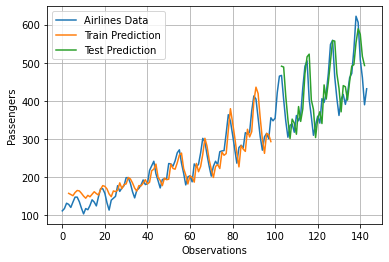

In [27]:
# MLP
print(xtrain.shape, ytrain.shape)

# fix random seed for reproducibility
np.random.seed(7)

# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Dense(8, input_dim = lookback, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

plot_model(model, to_file='MLP_Airline_Pass.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='MLP_Airline_Pass.png')

model.fit(xtrain, ytrain, epochs=500, batch_size=2, verbose=0)

# Estimate model performance
trainScore = model.evaluate(xtrain, ytrain, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(xtest, ytest, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# generate predictions for training
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lookback*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(minmax.inverse_transform(dataset), label="Airlines Data")
plt.plot(minmax.inverse_transform(trainPredictPlot), label="Train Prediction")
plt.plot(minmax.inverse_transform(testPredictPlot), label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

In [48]:
print(xtrain.shape)
# Reshape input to be [samples, time steps, features]
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))

print(xtrain.shape)
print(xtrain[0:3,:,:])

(96, 3)
(96, 1, 3)
[[[0.01544401 0.02702703 0.05405405]]

 [[0.02702703 0.05405405 0.04826255]]

 [[0.05405405 0.04826255 0.03281853]]]


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
None
Train Score: 0.04 RMSE
Test Score: 0.11 RMSE


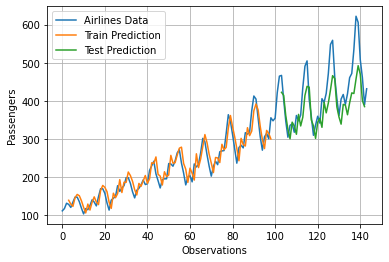

In [51]:
#RNN 
n_hidden = 4  # size of hidden layer in RNN
model = Sequential()
model.add(SimpleRNN(n_hidden, input_shape=(1, lookback)))
model.add(Dense(1, activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

model.fit(xtrain, ytrain, epochs=500, batch_size=2, verbose=0)

# make predictions
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lookback*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(minmax.inverse_transform(dataset), label="Airlines Data")
plt.plot(minmax.inverse_transform(trainPredictPlot), label="Train Prediction")
plt.plot(minmax.inverse_transform(testPredictPlot), label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________
None
Train Score: 0.04 RMSE
Test Score: 0.11 RMSE


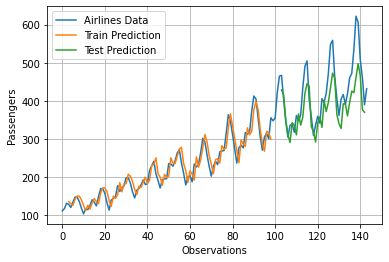

In [43]:
#LSTM 
model = Sequential()
model.add(LSTM(4, input_shape=(1, lookback)))
model.add(Dense(1, activation='tanh'))
model.compile(loss='mean_squared_error', optimizer='adam')

print(model.summary())

model.fit(xtrain, ytrain, epochs=500, batch_size=2, verbose=0)

# make predictions
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(lookback*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(minmax.inverse_transform(dataset), label="Airlines Data")
plt.plot(minmax.inverse_transform(trainPredictPlot), label="Train Prediction")
plt.plot(minmax.inverse_transform(testPredictPlot), label="Test Prediction")
plt.xlabel("Observations")
plt.ylabel("Passengers")
plt.legend()
plt.grid()
plt.show()